In [36]:
import torch
import torchvision


from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

from torch import optim


In [2]:
# load data
transformer = transforms.ToTensor()

train = FashionMNIST('data/',train=True,transform=transformer,download=False)
test = FashionMNIST('data/',train=False,transform=transformer,download=False)

#info about  data 
print("Train data have {} images".format(len(train)))
print("test data have {} images".format(len(test)))

Train data have 60000 images
test data have 10000 images


In [4]:
#creat data loader as torch work with it 
batch_size = 20
trainloader = DataLoader(train,batch_size=batch_size,shuffle=True)
testloader =  DataLoader(test,batch_size=batch_size,shuffle=True)


#### Data labels is :
   <img src="images\labels.png" />

In [5]:
# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize some training data 




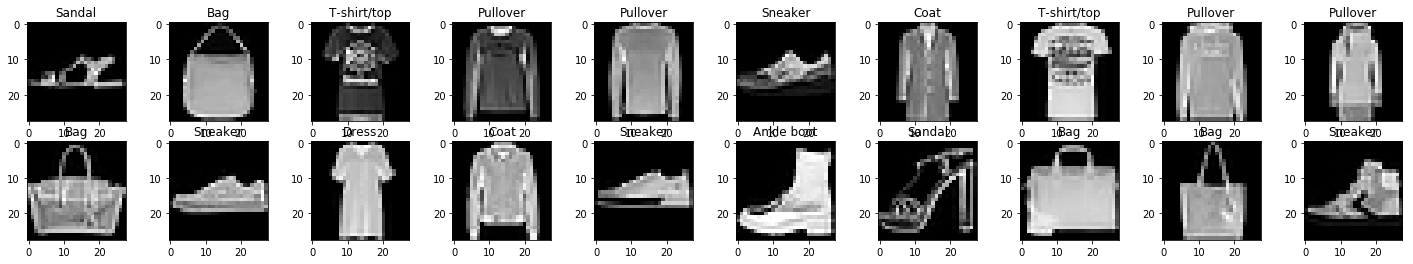

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


dataiter = iter(trainloader)
images , labels = dataiter.next()
images.numpy()
fig = plt.figure(figsize=(25,4))
for idx , image  in enumerate(images):
    ax = fig.add_subplot(2,10,idx+1)
    ax.imshow(np.squeeze(image),cmap='gray')
    ax.set_title(classes[labels[idx]])
   

## Build network 

In [58]:

class Net(nn.Module):
    
    def __init__(self):
        super(Net,self).__init__()
        # build arch of network
        self.conv1 = nn.Conv2d(1,16,3,padding=1)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.pool1 = nn.MaxPool2d(2,2) # 14 * 14
        self.conv3 = nn.Conv2d(32,64,3)
        self.fc = nn.Linear(12*12*64,10)
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0),-1)
        x = F.softmax(self.fc(x),dim=1)
        
        return x


net = Net().cuda()
print(net)



Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=9216, out_features=10, bias=True)
)


In [59]:
# Define loss and optimizer 
loss_fun = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

## Train our Model

In [63]:
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    epochloss = 0
    for batch_idx , data in enumerate(trainloader):
        inputs , labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        opt.zero_grad()
        out = net(inputs)
        loss = loss_fun(out,labels)
        loss.backward()
        opt.step()
        
        total_loss += loss.item()
        epochloss  += loss.item()
        if(batch_idx  %1000 == 999):
            print('Epoch {} , batch {} , loss {}'.format(epoch+1,batch_idx+1,total_loss/1000))
            total_loss = 0
    print('Epoch {} , loss {}'.format(epoch+1,epochloss))
    
    epochloss = 0

Epoch 1 , batch 1000 , loss 1.5317766987085342
Epoch 1 , batch 2000 , loss 1.5340490407943725
Epoch 1 , batch 3000 , loss 1.5372184534072877
Epoch 1 , loss 4603.044192910194
Epoch 2 , batch 1000 , loss 1.5348692746162416
Epoch 2 , batch 2000 , loss 1.530556829214096
Epoch 2 , batch 3000 , loss 1.5327118899822234
Epoch 2 , loss 4598.137993812561
Epoch 3 , batch 1000 , loss 1.531953416109085
Epoch 3 , batch 2000 , loss 1.5310056331157684
Epoch 3 , batch 3000 , loss 1.5334285221099853
Epoch 3 , loss 4596.387571334839
Epoch 4 , batch 1000 , loss 1.5313459683656692
Epoch 4 , batch 2000 , loss 1.529302552819252
Epoch 4 , batch 3000 , loss 1.5325089461803436
Epoch 4 , loss 4593.157467365265
Epoch 5 , batch 1000 , loss 1.529405172944069
Epoch 5 , batch 2000 , loss 1.5320793968439101
Epoch 5 , batch 3000 , loss 1.5333919426202773
Epoch 5 , loss 4594.8765124082565
Epoch 6 , batch 1000 , loss 1.5265997735261918
Epoch 6 , batch 2000 , loss 1.5340812264680863
Epoch 6 , batch 3000 , loss 1.531193789

In [71]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1).cuda()
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(testloader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    inputs = inputs.cuda()
    labels = labels.cuda()
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = loss_fun(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1).cuda() / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.cpu().numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 1.556149

Test Accuracy of T-shirt/top: 86% (869/1000)
Test Accuracy of Trouser: 97% (978/1000)
Test Accuracy of Pullover: 89% (897/1000)
Test Accuracy of Dress: 93% (932/1000)
Test Accuracy of  Coat: 78% (781/1000)
Test Accuracy of Sandal: 97% (971/1000)
Test Accuracy of Shirt: 69% (692/1000)
Test Accuracy of Sneaker: 97% (971/1000)
Test Accuracy of   Bag: 98% (986/1000)
Test Accuracy of Ankle boot: 97% (974/1000)

Test Accuracy (Overall): 90% (9051/10000)
